## Generating Pseudodata
### This cell needs LHAPDF to create the grid. If LHAPDF is not available, then use the pre-generated grid in the folder, and make sure it has columns for the PDFs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lhapdf
import pandas as pd

NNPDF4_nlo = lhapdf.mkPDF('NNPDF40_nlo_as_01180')
data = pd.read_csv("E288.csv")
alpha = 1 / 137

def pdf(pdfset, flavor, x, QQ):
    return pdfset.xfxQ2(flavor, x, QQ)

def S(k):
    return np.exp(-k**2)

def fDNNQ(QM, a=1.0, b=0.5):
    return a * QM * np.exp(-b * QM)

def compute_A_and_pdfs(x1, x2, qT, QM):
    f_u_x1 = pdf(NNPDF4_nlo, 2, x1, QM)
    f_ubar_x2 = pdf(NNPDF4_nlo, -2, x2, QM)
    f_u_x2 = pdf(NNPDF4_nlo, 2, x2, QM)
    f_ubar_x1 = pdf(NNPDF4_nlo, -2, x1, QM)

    Sk_contribution = (1 / 2) * (np.pi) * (np.exp(-qT * qT / 2))
    fDNN_contribution = fDNNQ(QM)

    ux1ubarx2_term = x1 * x2 * f_u_x1 * f_ubar_x2 * Sk_contribution * fDNN_contribution**2
    ubarx1ux2_term = x2 * x1 * f_u_x2 * f_ubar_x1 * Sk_contribution * fDNN_contribution**2
    FUU = ux1ubarx2_term + ubarx1ux2_term
    cross_section = FUU * qT * ((4 * np.pi * alpha)**2) / (9 * QM**3)
    return cross_section, f_u_x1, f_ubar_x2, f_u_x2, f_ubar_x1

x1_values = data['xA'].values
x2_values = data['xB'].values
qT_values = data['PT'].values
QM_values = data['QM'].values


results = [
    compute_A_and_pdfs(x1, x2, qT, QM)
    for x1, x2, qT, QM in zip(x1_values, x2_values, qT_values, QM_values)
]

A_values, f_u_x1_values, f_ubar_x2_values, f_u_x2_values, f_ubar_x1_values = zip(*results)


results_df = pd.DataFrame({
    'x1': x1_values,
    'x2': x2_values,
    'qT': qT_values,
    'QM': QM_values,
    'A': A_values,
    'f_u_x1': f_u_x1_values,
    'f_ubar_x2': f_ubar_x2_values,
    'f_u_x2': f_u_x2_values,
    'f_ubar_x1': f_ubar_x1_values,
})

results_df.to_csv("pseudodataE288_noLHAPDF.csv", index=False)
print("Computed A values and PDFs saved to pseudodataE288_noLHAPDF.csv")

LHAPDF 6.3.0 loading /Users/isharauva/LHAPDF/LHAPDF-Install/share/LHAPDF/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1
Computed A values and PDFs saved to pseudodataE288_noLHAPDF.csv


## Training

Folder 'Models_noLHAPDF' already exists!
Folder 'Results_noLHAPDF' already exists!
Epoch 1/1000, Loss: 2.127e-10
Epoch 101/1000, Loss: 2.125e-10
Epoch 201/1000, Loss: 2.121e-10
Epoch 301/1000, Loss: 2.115e-10
Epoch 401/1000, Loss: 2.110e-10
Epoch 501/1000, Loss: 2.103e-10
Epoch 601/1000, Loss: 2.096e-10
Epoch 701/1000, Loss: 2.088e-10
Epoch 801/1000, Loss: 2.080e-10
Epoch 901/1000, Loss: 2.071e-10
Epoch 1000/1000, Loss: 2.065e-10


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


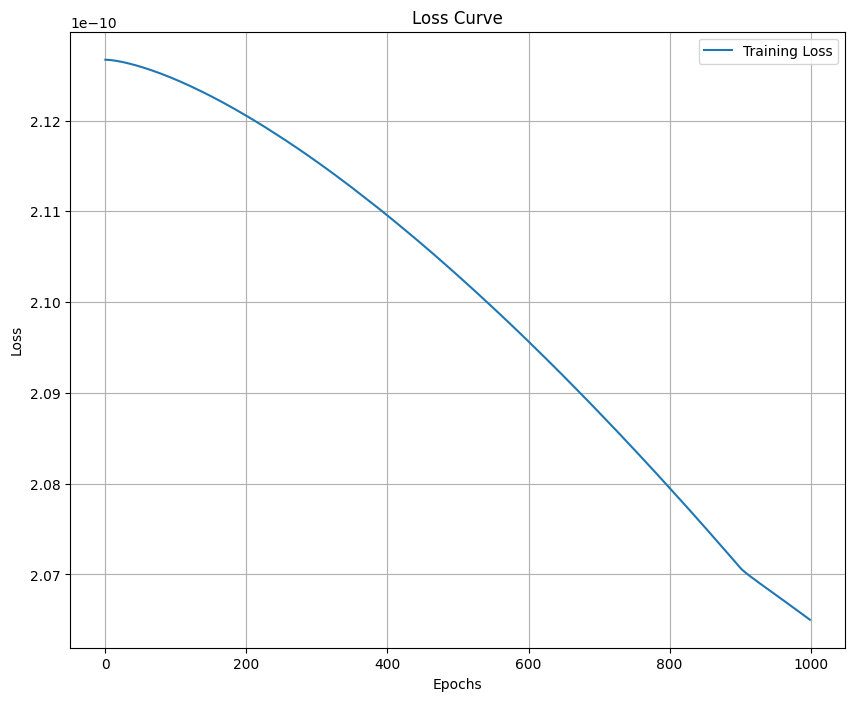

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


def create_folders(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully!")
    else:
        print(f"Folder '{folder_name}' already exists!")

models_folder = 'Models_noLHAPDF'
results_folder = 'Results_noLHAPDF'
create_folders(models_folder)
create_folders(results_folder)
alpha = 1 / 137


data = pd.read_csv("pseudodataE288_noLHAPDF.csv")
x1_values = tf.constant(data['x1'].values, dtype=tf.float32)
x2_values = tf.constant(data['x2'].values, dtype=tf.float32)
qT_values = tf.constant(data['qT'].values, dtype=tf.float32)
QM_values = tf.constant(data['QM'].values, dtype=tf.float32)
A_true_values = tf.constant(data['A'].values, dtype=tf.float32)


f_u_x1_values = tf.constant(data['f_u_x1'].values, dtype=tf.float32)
f_ubar_x2_values = tf.constant(data['f_ubar_x2'].values, dtype=tf.float32)
f_u_x2_values = tf.constant(data['f_u_x2'].values, dtype=tf.float32)
f_ubar_x1_values = tf.constant(data['f_ubar_x1'].values, dtype=tf.float32)


def DNNQ():
    return models.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(100, activation='relu6'),
        layers.Dense(100, activation='relu6'),
        layers.Dense(100, activation='relu6'),
        layers.Dense(1, activation='tanh')
        # layers.Dense(1, activation='exponential')
    ])

dnnQ = DNNQ()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs = 1000
print_epochs = 100


def custom_loss(A_true, x1, x2, qT, QM, f_u_x1, f_ubar_x2, f_u_x2, f_ubar_x1):
    dnnQinputs = tf.reshape(QM, (-1, 1))
    dnnQvals = dnnQ(dnnQinputs)

    pi = tf.constant(np.pi, dtype=tf.float32)
    Sk_contribution = (1 / 2) * pi * tf.exp(-qT**2 / 2)

    ux1ubarx2_term = x1 * x2 * f_u_x1 * f_ubar_x2 * Sk_contribution * dnnQvals * dnnQvals
    ubarx1ux2_term = x2 * x1 * f_u_x2 * f_ubar_x1 * Sk_contribution * dnnQvals * dnnQvals
    FUU = ux1ubarx2_term + ubarx1ux2_term
    cross_section = FUU * qT * ((4 * np.pi * alpha)**2) / (9 * QM**3)
    temploss = tf.abs(cross_section - A_true)
    loss = tf.reduce_mean(temploss)  # Mean absolute error loss
    return loss


losses = []
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = custom_loss(
            A_true_values, x1_values, x2_values, qT_values, QM_values,
            f_u_x1_values, f_ubar_x2_values, f_u_x2_values, f_ubar_x1_values
        )
    grads = tape.gradient(loss, dnnQ.trainable_variables)
    optimizer.apply_gradients(zip(grads, dnnQ.trainable_variables))
    losses.append(loss.numpy())

    if epoch % print_epochs == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy():.3e}")


dnnQ.save(os.path.join(str(models_folder), 'DNNQ_model.h5'))
print("Model saved successfully!")


plt.figure(figsize=(10, 8))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.savefig(str(results_folder)+'/Losses.pdf')
plt.show()


## Evaluation

2025-01-06 10:16:38.904486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


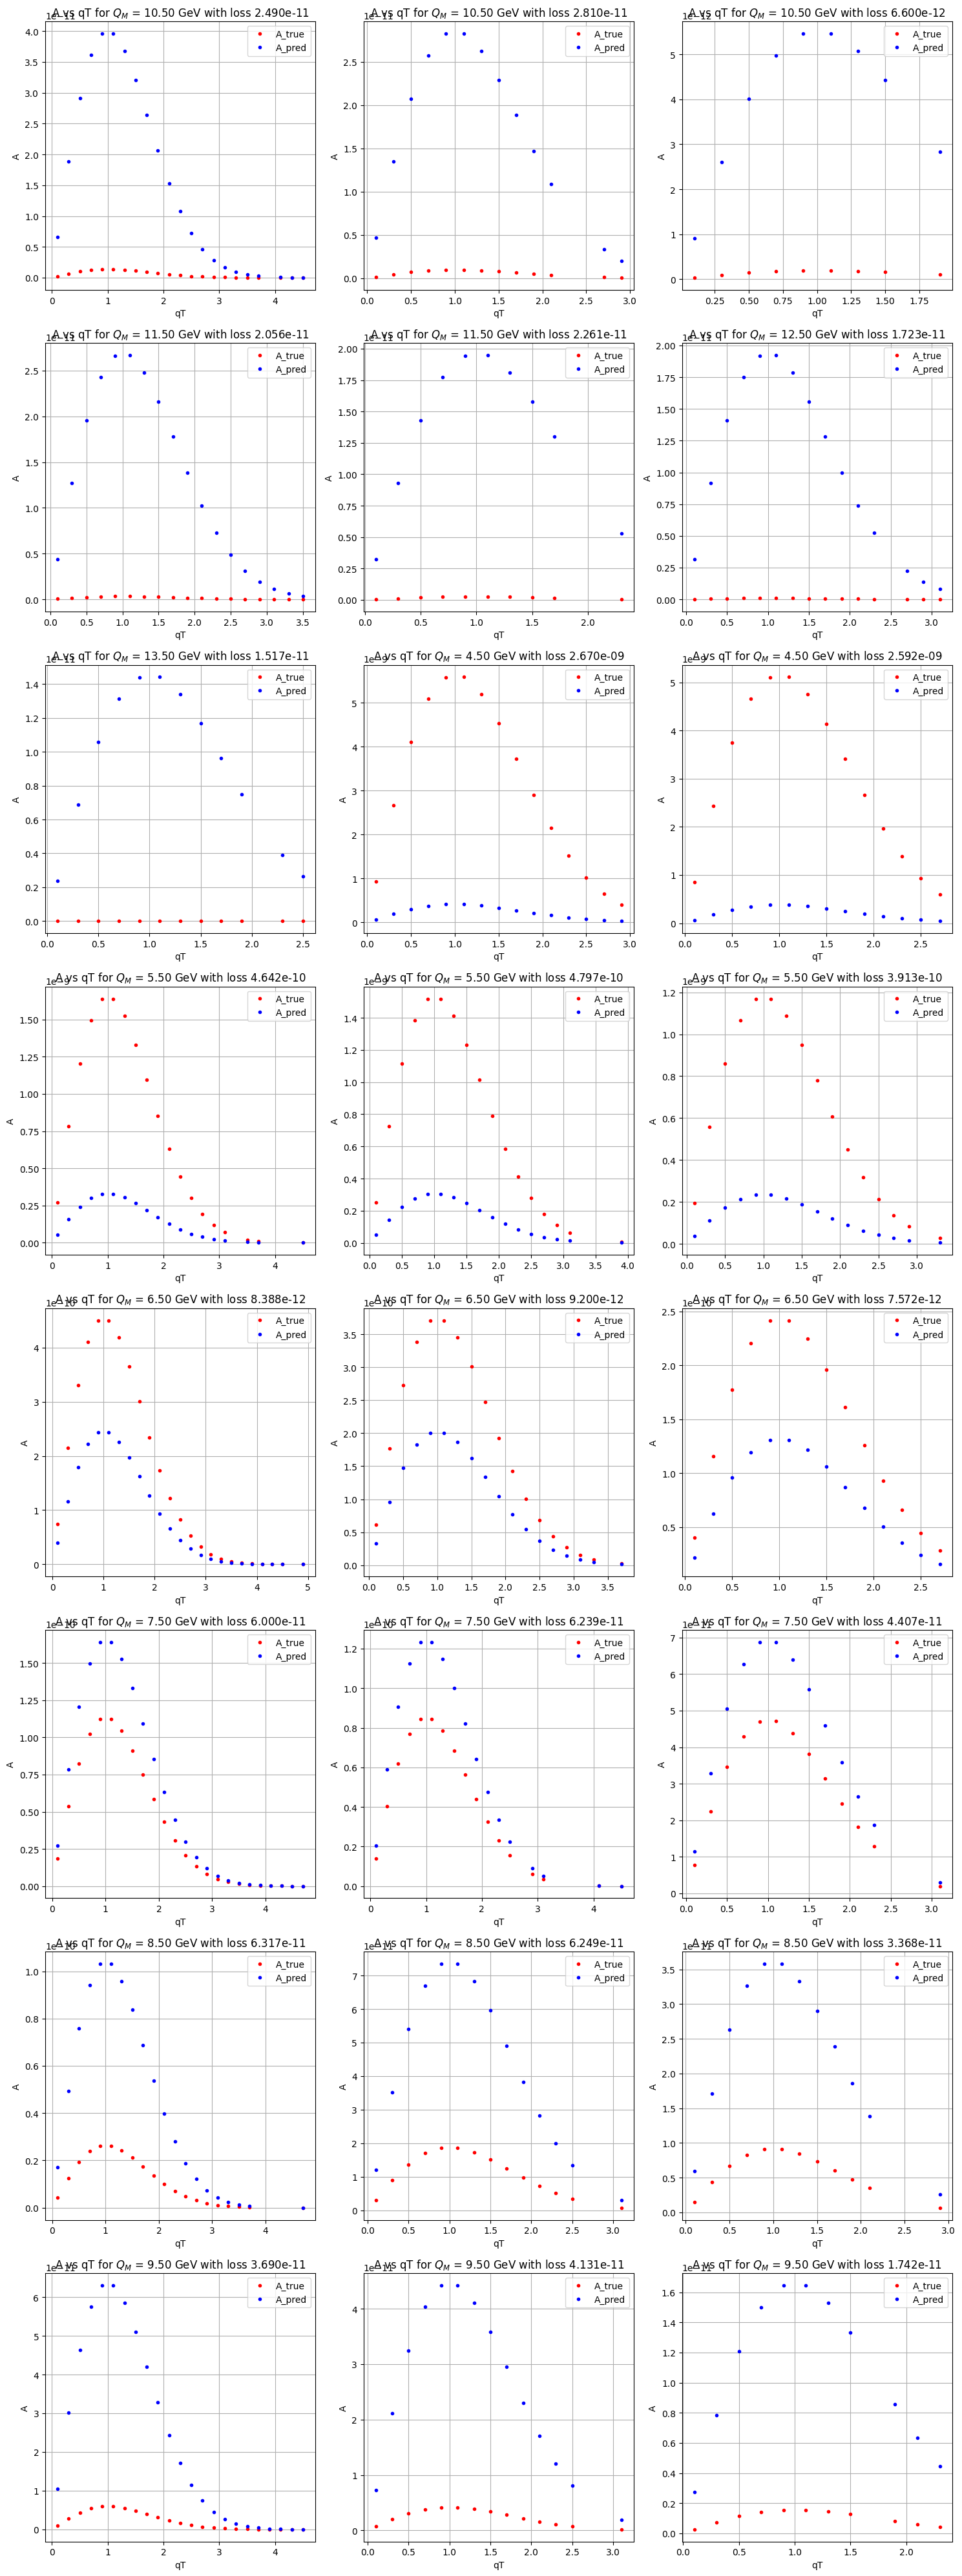

7/7 [==============================] - 0s 2ms/step


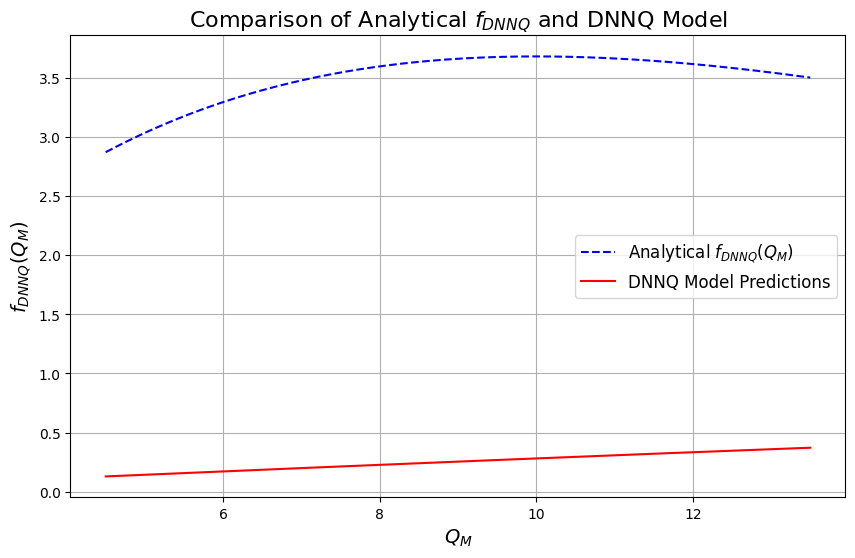

           x1        x2   qT    QM             A    f_u_x1  f_ubar_x2  \
0    0.206893  0.194844  0.1   5.5  2.716057e-10  0.679198   0.048348   
1    0.206893  0.194844  0.3   5.5  7.828677e-10  0.679198   0.048348   
2    0.206893  0.194844  0.5   5.5  1.204463e-09  0.679198   0.048348   
3    0.206893  0.194844  0.7   5.5  1.495568e-09  0.679198   0.048348   
4    0.206893  0.194844  0.9   5.5  1.638565e-09  0.679198   0.048348   
..        ...       ...  ...   ...           ...       ...        ...   
379  0.808678  0.363362  0.9  10.5  1.912990e-13  0.007179   0.006000   
380  0.808678  0.363362  1.1  10.5  1.914274e-13  0.007179   0.006000   
381  0.808678  0.363362  1.3  10.5  1.779607e-13  0.007179   0.006000   
382  0.808678  0.363362  1.5  10.5  1.551920e-13  0.007179   0.006000   
383  0.808678  0.363362  1.9  10.5  9.958904e-14  0.007179   0.006000   

       f_u_x2  f_ubar_x1                  unique_group        A_pred  
0    0.683695    0.04274   5.5_0.206892673_0.1948441

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
import os


models_folder = 'Models_noLHAPDF'
results_folder = 'Results_noLHAPDF'
dnnQ_model = load_model(os.path.join(models_folder, "DNNQ_model.h5"))


pseudo_df = pd.read_csv("pseudodataE288_noLHAPDF.csv")
alpha = 1 / 137  # Fine-structure constant

def custom_loss(A_true, x1, x2, qT, QM, f_u_x1, f_ubar_x2, f_u_x2, f_ubar_x1):
    A_true = tf.constant(A_true, dtype=tf.float32)
    x1 = tf.constant(x1, dtype=tf.float32)
    x2 = tf.constant(x2, dtype=tf.float32)
    qT = tf.constant(qT, dtype=tf.float32)
    QM = tf.constant(QM, dtype=tf.float32)
    f_u_x1 = tf.constant(f_u_x1, dtype=tf.float32)
    f_ubar_x2 = tf.constant(f_ubar_x2, dtype=tf.float32)
    f_u_x2 = tf.constant(f_u_x2, dtype=tf.float32)
    f_ubar_x1 = tf.constant(f_ubar_x1, dtype=tf.float32)

    QM_reshaped = tf.reshape(QM, (-1, 1))
    dnnQvals = tf.squeeze(dnnQ_model(QM_reshaped), axis=-1)

    Sk_contribution = (1 / 2) * np.pi * tf.exp(-qT**2 / 2)

    ux1ubarx2_term = x1 * x2 * f_u_x1 * f_ubar_x2 * Sk_contribution * dnnQvals**2
    ubarx1ux2_term = x2 * x1 * f_u_x2 * f_ubar_x1 * Sk_contribution * dnnQvals**2
    FUU = ux1ubarx2_term + ubarx1ux2_term
    cross_section = FUU * qT * ((4 * np.pi * alpha)**2) / (9 * QM**3)
    loss = tf.reduce_mean(tf.abs(cross_section - A_true))
    return loss.numpy()

def compute_A(x1, x2, qT, QM, f_u_x1, f_ubar_x2, f_u_x2, f_ubar_x1):
    Sk_contribution = (1 / 2) * np.pi * np.exp(-qT**2 / 2)
    QM_input = QM.reshape(-1, 1)
    fDNN_contribution = dnnQ_model.predict(QM_input, verbose=0).flatten()

    ux1ubarx2_term = x1 * x2 * f_u_x1 * f_ubar_x2 * Sk_contribution * fDNN_contribution**2
    ubarx1ux2_term = x2 * x1 * f_u_x2 * f_ubar_x1 * Sk_contribution * fDNN_contribution**2
    FUU = ux1ubarx2_term + ubarx1ux2_term
    cross_section = FUU * qT * ((4 * np.pi * alpha)**2) / (9 * QM**3)
    return cross_section

def data_theory_plots(ax, df):
    A_true = df['A'].values
    qT = df['qT'].values
    QM = df['QM'].values
    x1 = df['x1'].values
    x2 = df['x2'].values
    f_u_x1 = df['f_u_x1'].values
    f_ubar_x2 = df['f_ubar_x2'].values
    f_u_x2 = df['f_u_x2'].values
    f_ubar_x1 = df['f_ubar_x1'].values

    A_pred = compute_A(x1, x2, qT, QM, f_u_x1, f_ubar_x2, f_u_x2, f_ubar_x1)
    temp_loss = custom_loss(A_true, x1, x2, qT, QM, f_u_x1, f_ubar_x2, f_u_x2, f_ubar_x1)

    ax.plot(qT, A_true, '.', color='red', label='A_true')
    ax.plot(qT, A_pred, '.', color='blue', label='A_pred')
    ax.set_title(f'A vs qT for $Q_M$ = {QM[0]:.2f} GeV with loss {temp_loss:.3e}')
    ax.set_xlabel('qT')
    ax.set_ylabel('A')
    ax.legend()
    ax.grid(True)


pseudo_df["unique_group"] = pseudo_df["QM"].astype(str) + "_" + pseudo_df["x1"].astype(str) + "_" + pseudo_df["x2"].astype(str)
groups = pseudo_df.groupby("unique_group")
n_groups = groups.ngroups
ncols = 3
nrows = (n_groups + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for idx, (group_name, group_df) in enumerate(groups):
    data_theory_plots(axes[idx], group_df)

# for ax in axes[n_groups:]:
#     ax.axis('off')

plt.tight_layout()
plt.savefig(str(results_folder)+'/QM_subplots_with_predictions_noLHAPDF.pdf')
plt.show()


def fDNNQ(QM, a=1.0, b=0.1):
    return a * QM * np.exp(-b * QM)

QM_values_data = pseudo_df['QM'].values
QM_min, QM_max = QM_values_data.min(), QM_values_data.max()
QM_values = np.linspace(QM_min, QM_max, 200) 

QM_tensor = QM_values.reshape(-1, 1)
dnnQ_predictions = dnnQ_model.predict(QM_tensor).flatten()  
fDNNQ_values = fDNNQ(QM_values)


plt.figure(figsize=(10, 6))
plt.plot(QM_values, fDNNQ_values, label=r'Analytical $f_{DNNQ}(Q_M)$', linestyle='--', color='blue')
plt.plot(QM_values, dnnQ_predictions, label='DNNQ Model Predictions', linestyle='-', color='red')
plt.xlabel(r'$Q_M$', fontsize=14)
plt.ylabel(r'$f_{DNNQ}(Q_M)$', fontsize=14)
plt.title('Comparison of Analytical $f_{DNNQ}$ and DNNQ Model', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(str(results_folder)+'/QM_comparison_plot.pdf')
plt.show()


def data_theory_csv(df):
    A_true = df['A'].values
    qT = df['qT'].values
    QM = df['QM'].values
    x1 = df['x1'].values
    x2 = df['x2'].values
    f_u_x1_values=df['f_u_x1'].values
    f_ubar_x2_values=df['f_ubar_x2'].values
    f_u_x2_values=df['f_u_x2'].values
    f_ubar_x1_values=df['f_ubar_x1'].values
    A_pred = compute_A(x1, x2, qT, QM,f_u_x1_values,f_ubar_x2_values,f_u_x2_values,f_ubar_x1_values)
    df['A_pred'] = A_pred
    return df

tempresultdf=data_theory_csv(pseudo_df)
tempresultdf.to_csv(str(results_folder)+'/Results_pseudodataE288_no_LHAPDF.csv', index=False)
print(tempresultdf)